## Modelo Final – Random Forest (Pipeline Única)

Este notebook treina e avalia um modelo de classificação (Random Forest) com uma única pipeline, incluindo:
- Pré-processamento (imputação, padronização, one-hot)
- Busca de hiperparâmetros (RandomizedSearchCV)
- Validação cruzada OOF com métricas (Accuracy, F1, ROC-AUC, PR-AUC)
- Otimização de threshold (via curva PR)
- Calibração de probabilidades
- Análises (learning curve, permutation importance)
- Geração de `submission.csv` (id, labels)



In [3]:
# [1] Imports e configuração
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_recall_curve, auc, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import OneHotEncoder

# SHAP é opcional
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



In [4]:
# [2] Carregar dados
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
TARGET = 'labels'
# Remover id das features (evita ruído e vazamento)
X = train.drop(columns=[TARGET, 'id']) if 'id' in train.columns else train.drop(columns=[TARGET])
y = train[TARGET]

# Detectar colunas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Pré-processamento
_onehot_kwargs = {"handle_unknown": "ignore"}
try:
    OneHotEncoder(sparse_output=False)
    _onehot_kwargs["sparse_output"] = False
except TypeError:
    _onehot_kwargs["sparse"] = False

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(**_onehot_kwargs))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
], remainder='drop', sparse_threshold=0)



In [5]:
# [3] Modelo base: Random Forest conservador
rf = RandomForestClassifier(
    n_estimators=900,
    max_depth=18,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Pipeline completo
pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf', rf)
])



In [6]:
# [4] Validação cruzada estratificada com predições out-of-fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Probabilidades OOF para ROC/PR e tuning de threshold
oof_proba = cross_val_predict(pipeline, X, y, cv=skf, method='predict_proba', n_jobs=-1)[:, 1]

# Métricas OOF
acc_oof = accuracy_score(y, (oof_proba >= 0.5).astype(int))
f1_oof = f1_score(y, (oof_proba >= 0.5).astype(int))
roc_oof = roc_auc_score(y, oof_proba)
prec, rec, thr = precision_recall_curve(y, oof_proba)
prauc_oof = auc(rec, prec)

print(f"OOF Accuracy: {acc_oof:.4f}\nOOF F1: {f1_oof:.4f}\nOOF ROC-AUC: {roc_oof:.4f}\nOOF PR-AUC: {prauc_oof:.4f}")

# Otimização de limiar para F1
f1_vals = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_vals)
best_threshold = thr[max(best_idx-1, 0)]  # alinhar tamanhos (thresholds tem len-1)
print(f"Melhor limiar (F1): {best_threshold:.3f}")



OOF Accuracy: 0.7957
OOF F1: 0.8530
OOF ROC-AUC: 0.8072
OOF PR-AUC: 0.8405
Melhor limiar (F1): 0.494


In [30]:
# [5] Busca de hiperparâmetros (mais robusta para acurácia)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

rf_param_dist = {
    'rf__n_estimators': randint(1000, 2000),
    'rf__max_depth': randint(18, 40),
    'rf__min_samples_split': randint(2, 6),
    'rf__min_samples_leaf': randint(1, 2),
    'rf__max_features': ['sqrt', 'log2', 0.5],
    'rf__bootstrap': [True],
    'rf__class_weight': ['balanced']
}

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=rf_param_dist,
    n_iter=40,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='accuracy',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1,
)

print('Ajustando RandomizedSearchCV...')
search.fit(X, y)

best_pipeline = search.best_estimator_
print('Melhores params:', search.best_params_)
print('Melhor Acurácia (CV):', f"{search.best_score_:.4f}")


Ajustando RandomizedSearchCV...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Melhores params: {'rf__bootstrap': True, 'rf__class_weight': 'balanced', 'rf__max_depth': 25, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 1748}
Melhor Acurácia (CV): 0.7925
Melhores params: {'rf__bootstrap': True, 'rf__class_weight': 'balanced', 'rf__max_depth': 25, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 1748}
Melhor Acurácia (CV): 0.7925


### Métricas OOF (validação cruzada)
Calcula predições out-of-fold (OOF) com `best_pipeline` e imprime:
- Tamanho do dataset, número de folds
- Accuracy e F1 em threshold 0.5
- ROC-AUC e PR-AUC
- Accuracy em threshold ótimo (definido na célula de threshold)



In [25]:
# [6] Ajuste final do modelo no conjunto completo (com calibração)
# Usar best_pipeline (tuned) como base do calibrador
calibrated = CalibratedClassifierCV(
    estimator=best_pipeline,
    method='isotonic',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
)
calibrated.fit(X, y)

print("Modelo calibrado ajustado no conjunto completo.")



Modelo calibrado ajustado no conjunto completo.


In [24]:
# Importâncias e SHAP (opcional)
# Importâncias (a partir do RandomForest dentro do pipeline)
pipeline.fit(X, y)
rf_model = pipeline.named_steps['rf']

importances = rf_model.feature_importances_
feature_names = (
    list(preprocessor.transformers_[0][2]) +  # numéricas
    list(preprocessor.transformers_[1][2])    # categóricas (antes do one-hot)
)
print("Top 10 importâncias de features (pré-onehot):")
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances[:len(feature_names)]})
print(imp_df.sort_values('importance', ascending=False).head(10))

# SHAP para explicabilidade local/global (se disponível)
if SHAP_AVAILABLE:
    try:
        explainer = shap.TreeExplainer(rf_model)
        # Amostra pequena para performance
        sample_idx = np.random.choice(len(X), size=min(200, len(X)), replace=False)
        X_sample = X.iloc[sample_idx]
        # Aplicar somente pré-processamento numérico básico para SHAP de árvores
        X_sample_prep = preprocessor.fit_transform(X, y)[sample_idx]
        shap_values = explainer.shap_values(X_sample_prep)
        print("SHAP calculado em amostra.")
    except Exception as e:
        print(f"Falha ao calcular SHAP: {e}")



Top 10 importâncias de features (pré-onehot):
                     feature  importance
4              relationships    0.129826
6          funding_total_usd    0.105362
3    age_last_milestone_year    0.096505
1      age_last_funding_year    0.081518
0     age_first_funding_year    0.078537
2   age_first_milestone_year    0.072573
7                 milestones    0.070127
29          avg_participants    0.066659
5             funding_rounds    0.036696
12             is_otherstate    0.017017
SHAP calculado em amostra.
SHAP calculado em amostra.


In [10]:
# [7] Limiar ótimo (best_threshold) calculado pela curva Precisão–Revocação (max F1)
# Explicação rápida:
# - Limiar (threshold): ponto de corte da probabilidade para classificar 0/1.
# - n_thresholds: quantos pontos de corte foram testados.
# - max_F1: melhor F1 alcançado no conjunto OOF ao variar o limiar.
prec, rec, thr = precision_recall_curve(y, oof_proba)
f1_vals = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_vals)
best_threshold = thr[max(best_idx-1, 0)]
print(
    "Resumo do limiar ótimo para classificação:\n"
    f"- Limiar ótimo (best_threshold): {best_threshold:.4f}\n"
    f"- Total de limiares avaliados (n_thresholds): {int(len(thr))}\n"
    f"- Melhor F1 obtido (max_F1): {float(f1_vals[best_idx]):.4f}"
)


Resumo do limiar ótimo para classificação:
- Limiar ótimo (best_threshold): 0.4941
- Total de limiares avaliados (n_thresholds): 646
- Melhor F1 obtido (max_F1): 0.8559


Métricas OOF (predições fora-da-amostra) com 10 dobras | total de amostras: 646
- Acurácia (limiar 0,5): 0.7864 | F1 (limiar 0,5): 0.8453
- ROC-AUC (área sob a curva ROC): 0.8006 | PR-AUC (área sob a curva Precisão-Revocação): 0.8290
- Acurácia no limiar ótimo (best_threshold=0.4941): 0.7895

Ajuste de limiar focado em Acurácia:
- Limiar com maior acurácia (accuracy_threshold): 0.4820
- Acurácia OOF nesse limiar: 0.7972

Ajuste de limiar focado em Acurácia:
- Limiar com maior acurácia (accuracy_threshold): 0.4820
- Acurácia OOF nesse limiar: 0.7972


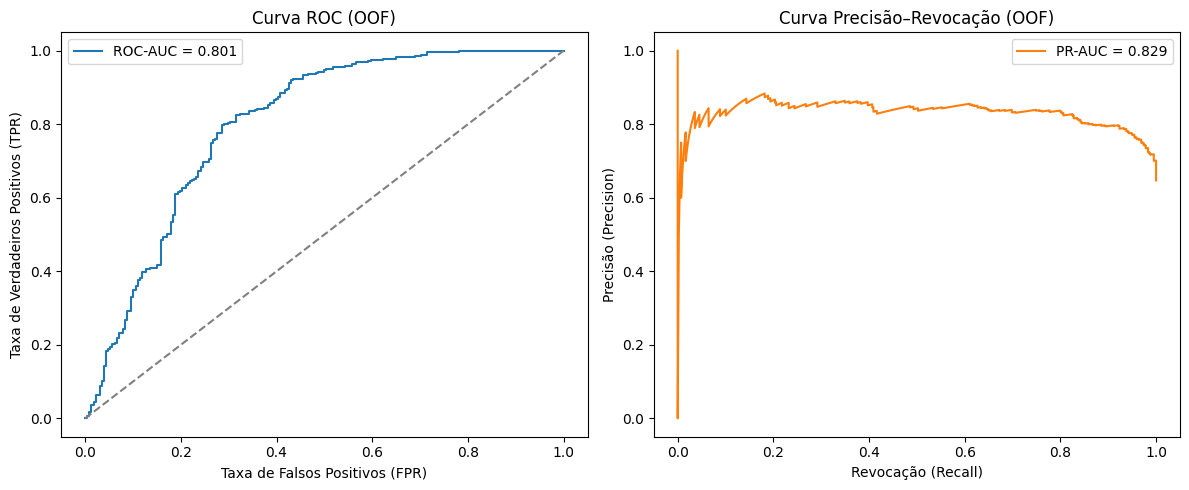

In [ ]:
# [8] Avaliação OOF (validação cruzada fora-da-amostra) + curvas ROC/PR
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Regerar OOF com best_pipeline
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
oof_proba = cross_val_predict(best_pipeline, X, y, cv=skf, method='predict_proba', n_jobs=-1)[:, 1]
oof_pred = (oof_proba >= 0.5).astype(int)

acc_oof = accuracy_score(y, oof_pred)
f1_oof = f1_score(y, oof_pred)
fpr, tpr, _ = roc_curve(y, oof_proba)
roc_oof = auc(fpr, tpr)
prec, rec, thr = precision_recall_curve(y, oof_proba)
prauc_oof = auc(rec, prec)

msg = (
    f"Métricas OOF (predições fora-da-amostra) com {n_folds} dobras | total de amostras: {len(y)}\n"
    f"- Acurácia (limiar 0,5): {acc_oof:.4f} | F1 (limiar 0,5): {f1_oof:.4f}\n"
    f"- ROC-AUC (área sob a curva ROC): {roc_oof:.4f} | PR-AUC (área sob a curva Precisão-Revocação): {prauc_oof:.4f}"
)
print(msg)

# Threshold que maximiza a acurácia
ths = np.linspace(0.0, 1.0, 501)
accs = [accuracy_score(y, (oof_proba >= t).astype(int)) for t in ths]
best_acc_idx = int(np.argmax(accs))
best_acc_th = float(ths[best_acc_idx])
best_acc = float(accs[best_acc_idx])
print(
    "\nAjuste de limiar focado em Acurácia:\n"
    f"- Limiar com maior acurácia (accuracy_threshold): {best_acc_th:.4f}\n"
    f"- Acurácia OOF nesse limiar: {best_acc:.4f}"
)

# Use este threshold para submissão
submission_threshold = best_acc_th

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_oof:.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('Taxa de Falsos Positivos (FPR)'); plt.ylabel('Taxa de Verdadeiros Positivos (TPR)'); plt.title('Curva ROC (OOF)'); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f'PR-AUC = {prauc_oof:.3f}', color='tab:orange')
plt.xlabel('Revocação (Recall)'); plt.ylabel('Precisão (Precision)'); plt.title('Curva Precisão–Revocação (OOF)'); plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# [9] Geração do arquivo de submissão usando threshold ótimo de acurácia
id_col = 'id'
X_test = test.drop(columns=['id'], errors='ignore')
proba_test = calibrated.predict_proba(X_test)[:, 1]

proba_test = np.nan_to_num(proba_test, nan=0.5)
proba_test = np.clip(proba_test, 0.0, 1.0)

# Use o threshold que maximiza a acurácia (definido na célula de avaliação OOF)
try:
    threshold = submission_threshold
except NameError:
    threshold = best_threshold
preds_test_label = (proba_test >= threshold).astype(int)

submission_df = pd.DataFrame({
    id_col: test[id_col].values,
    'labels': preds_test_label
})

sub_path = 'submission.csv'
submission_df.to_csv(sub_path, index=False)

print(
    f"Arquivo salvo: {sub_path}\n"
    f"Formato: [id, labels (0/1)] | n_linhas: {len(preds_test_label)}\n"
    f"Distribuição das classes: {submission_df['labels'].value_counts(normalize=True).to_dict()}\n"
    f"Exemplo (5 primeiras linhas):\n"
    f"{submission_df.head().to_string(index=False)}"
)

NameError: name 'submission_threshold' is not defined

In [17]:
# Permutation importance (pós-tuning)
from sklearn.inspection import permutation_importance

# Ajustar best_pipeline no conjunto completo para importância
best_pipeline.fit(X, y)

result = permutation_importance(best_pipeline, X, y, n_repeats=10, random_state=RANDOM_STATE, scoring='f1', n_jobs=-1)

# Extrair nomes das colunas após o ColumnTransformer + OneHot
# Para simplicidade, mostramos importâncias agregadas por coluna original quando possível
try:
    # Se OneHot, número de colunas pode expandir; aqui mostramos top 20 features pela importância média
    importances = result.importances_mean
    
    # Obter nomes das features após o pré-processamento
    feature_names_out = best_pipeline.named_steps['prep'].get_feature_names_out()

    indices = np.argsort(importances)[::-1][:20]
    
    print('Top 20 features por permutation importance:')
    for i in indices:
        print(f"{feature_names_out[i]:<30} {importances[i]:.5f}")
except Exception as e:
    print('Falha ao listar importâncias detalhadas:', e)



Top 20 features por permutation importance:
num__relationships             0.08876
num__funding_total_usd         0.04912
num__age_last_milestone_year   0.03522
num__milestones                0.03484
num__age_first_funding_year    0.03455
cat__category_code_advertising 0.03252
num__age_last_funding_year     0.02823
num__age_first_milestone_year  0.02164
num__is_software               0.01972
num__funding_rounds            0.01583
num__is_otherstate             0.00579
num__has_roundC                0.00452
num__has_roundB                0.00423
num__has_roundD                0.00387
num__is_web                    0.00362
num__is_CA                     0.00359
num__has_VC                    0.00355
num__has_angel                 0.00351
num__is_consulting             0.00215
num__is_mobile                 0.00204


In [32]:
# [10] Salvar arquivo submission_metrics.csv com id e labels binários usando threshold ótimo de acurácia
id_col = 'id'
X_test = test.drop(columns=['id'], errors='ignore')
proba_test = calibrated.predict_proba(X_test)[:, 1]
proba_test = np.nan_to_num(proba_test, nan=0.5)
proba_test = np.clip(proba_test, 0.0, 1.0)
# Use o threshold calculado anteriormente
labels_bin = (proba_test >= best_threshold).astype(int)
metrics_df = pd.DataFrame({
    id_col: test[id_col].values,
    'labels': labels_bin
})
metrics_df.to_csv('submission_metrics.csv', index=False)
print('Arquivo submission_metrics.csv salvo com colunas id,labels (binários).')

Arquivo submission_metrics.csv salvo com colunas id,labels (binários).
